In [1]:
import numpy as np
from numpy.lib.scimath import sqrt # allow sqrt to return complex numbers
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
plt.style.use('fivethirtyeight')

# Building Quiz_05

![Swinging pendulum in viscous fluid](../images/pendulum-viscous.svg)

A pendulum is placed inside a viscous fluid. The motion of the pendulum is subject to 2 external forces:
- gravity: $$F_g = mg$$
- viscous damping: $$F_f =-b\mathbf{v}= -bL\dot{\theta}\hat{e}_{\theta}$$

The final equation of motion is as such

$$\ddot{\theta}+\frac{b}{m}\dot{\theta}+\frac{g}{L}\sin\theta = 0$$

a. Find the variation in the Lagrangian, $$\delta L$$

b. Write the nonconservative virtual work, $$\delta W^{NC}$$

c. Show that $$\delta L + \delta W^{NC}=0$$ results in the final equation of motion. 

## Linear solution

Equation of motion in a linearized system:

$$\ddot{\theta}+\frac{b}{m}\dot{\theta}+\frac{g}{L}\theta = 0$$

$$\ddot{\theta}+2\zeta\omega\dot{\theta}+\omega^2\theta = 0$$

where

- $\omega = \sqrt{\frac{g}{L}}$
- $\zeta = \frac{b}{2m}\sqrt{\frac{l}{g}}$

This is a [damped harmonic oscillator](https://en.wikipedia.org/wiki/Harmonic_oscillator), so the solution will come in 3 forms:

1. underdamped $\zeta<1$
2. critically damped $\zeta = 1$
3. overdamped $\zeta > 1$

Consider a pendulum with length, $L=1~m$, mass of $m=0.1~kg$, and 3 different damping ratios:

|$\zeta$|b [kg/s] |
|---|---|
|0.1|0.063|
|1 |0.63|
|2 |1.25|

$\theta(t) = e^{-\zeta\omega t}(a_1 e^{i\omega t\sqrt{1-\zeta^2}} + a_2 e^{-i\omega t\sqrt{1-\zeta^2}})$

$\dot{\theta}(t) = -\zeta\omega e^{-\zeta\omega t}(a_1 e^{i\omega t\sqrt{1-\zeta^2}} + a_2 e^{-i\omega t\sqrt{1-\zeta^2}})
+i\omega \sqrt{1-\zeta^2}e^{-\zeta\omega t}(a_1 e^{i\omega t\sqrt{1-\zeta^2}} - a_2 e^{-i\omega t\sqrt{1-\zeta^2}})$



$$\theta_0 = a_1 +a_2$$
$$\dot{\theta}_0 = -\zeta\omega (a_1 +a_2) +i\omega\sqrt{1-\zeta^2}(a_1-a_2)$$

> __Note__: The default `np.sqrt` returns an error if you ask for
> `np.sqrt(-1)`. Above, the `numpy.lib.scimath.sqrt` is imported to
> allow complex number algebra as such:
> `from numpy.lib.scimath import sqrt`


In [2]:
L = 1
g = 9.81
m = 0.1
z = 0.1
w = sqrt(g/L)
def find_constants(state0, z):
    A = np.array([[1, 1], 
                  [1j*w*sqrt(1-z**2)-z*w, -1j*w*sqrt(1-z**2)-z*w]])
    b = np.array(state0)

    a = np.linalg.solve(A,b)
    return a

In [3]:
theta = lambda t, a, z: np.exp(-w*z*t)*(a[0]*np.exp(1j*w*t*sqrt(1-z**2))+a[1]*np.exp(-1j*w*t*sqrt(1-z**2)))
dtheta = lambda t, a, z: -w*z*np.exp(-w*z*t)*(a[0]*np.exp(1j*w*t*sqrt(1-z**2)) +\
                                              a[1]*np.exp(-1j*w*t*sqrt(1-z**2)))+\
                        1j*w*t*sqrt(1-z**2)*np.exp(-w*z*t)*(a[0]*np.exp(1j*w*t*sqrt(1-z**2)) -\
                                              a[1]*np.exp(-1j*w*t*sqrt(1-z**2)))

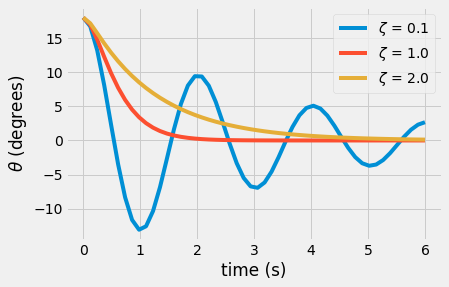

In [27]:
t = np.linspace(0,6)
for z in [0.1, 0.9999, 2]:
    a = find_constants([np.pi/10, 0], z)
    plt.plot(t, 180/np.pi*theta(t, a, z).real, label = r'$\zeta$ = {:.1f}'.format(z))
plt.xlabel('time (s)')
plt.ylabel(r'$\theta$ (degrees)')
plt.legend()

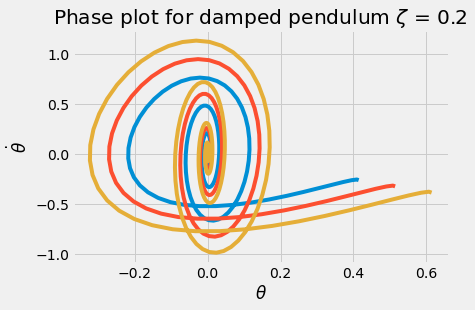

In [30]:
z= 0.2 #0.9999
t = np.linspace(0,10, 200)
for pert in [0.1, 0.2, 0.3]:
    a = find_constants([np.pi/10+pert, 0], z)
    plt.plot(theta(t, a, z).real, dtheta(t, a, z).real)

plt.title('Phase plot for damped pendulum $\zeta$ = {:.1f}'.format(z))
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\dot{\theta}$');

## Approximate _nonlinear_ solution

The final equation of motion is not linear for $\theta \approx 1$, 

$$\ddot{\theta}+\frac{b}{m}\dot{\theta}+\frac{g}{L}\sin\theta = 0.$$

You can numerically integrate this equation for any angle $\theta$

1. create 2 first-order differential equations $\dot{\mathbf{y}} = f(\mathbf{y})$ where $\mathbf{y}=[\theta,~\dot{\theta}]$

2. use `solve_ivp` to integrate the equation with initial conditions



In [6]:
def damped_pendulum(t, y, z, w=sqrt(g/L)):
    '''
    damped_pendulum(t, y, z, w)
    
    Return the derivative for a damped pendulum system
    dy[1] + 2*z*w*y[1] + w**2*sin(y[0])
    
    Parameters
    ----------
    t: current time
    y: current state = [theta (rad), dtheta/dt (rad/s)]
    z: damping ratio (determined from eqn of motion)
    w: natural frequency for linear system
    
    Returns
    -------
    dy: derivative of state, y, at time, t 
        [dtheta/ddt (rad/s), ddtheta/ddt (rad/s/s)]

    '''
    dy = np.zeros(y.shape)
    dy[0] = y[1]
    dy[1] = -2*w*z*y[1] - w**2*np.sin(y[0])
    return dy

### Integrate the _exact_ differential equation with an _approximation_

The differential equation is now exact, but you don't have a way to solve for the exact function $\theta(t)$. Use the function [`solve_ivp`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html) to find the solution over a given time interval `[0, 10]` seconds and evaluated at the same points as the previous linear solution, `t_eval = t`. 

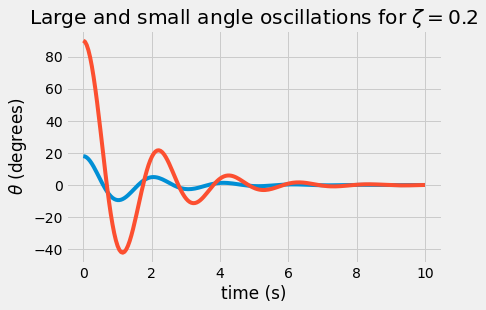

In [37]:
sol = solve_ivp(lambda t, y: damped_pendulum(t, y, 0.2), 
                [0, 10], # timespan [ 0s to 10s]
                [np.pi/10, 0], # initial conditions [18 deg, 0 rad/s]
                t_eval = t)

plt.plot(sol.t, 180/np.pi*sol.y[0])
sol = solve_ivp(lambda t, y: damped_pendulum(t, y, 0.2), 
                [0, 10], # timespan [ 0s to 10s]
                [np.pi/2, 0], # initial conditions [90 deg, 0 rad/s]
                t_eval = t)

plt.plot(sol.t, 180/np.pi*sol.y[0])
plt.xlabel('time (s)')
plt.ylabel(r'$\theta$ (degrees)')
plt.title(r'Large and small angle oscillations for $\zeta=0.2$');

## Wrapping up

You have created 2 solutions for the damped pendulum differential equation:
1. exact solution to the linearized differential equation
2. approximate integration of the _exact_ differential equation